# ScRNA-Seq of human PBMCs

In [1]:
# Import packages
import scanpy as sc
import pandas as pd
from functions import data_preprocessing as dp
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

## Read AnnData and add metadata information

In [2]:
file_paths = '../../../../data/processed/immune_cells/pbmcs_human/'

filenames = ['PBMCs_6_adata.h5ad']

adata = []
for k, name in enumerate(filenames):
    file = file_paths + name
    adata_temp = sc.read(file, cache=True)
    adata_temp.obs['patientID'] = ['10X']*adata_temp.n_obs
    adata_temp.obs['study'] = ['10X']*adata_temp.n_obs
    adata_temp.obs['chemistry'] = ['v3_10X']*adata_temp.n_obs
    adata_temp.obs['tissue'] = ['PBMCs']*adata_temp.n_obs
    adata_temp.obs['species'] = ['Human']*adata_temp.n_obs
    adata_temp.obs['data_type'] = ['UMI']*adata_temp.n_obs
    adata.append(adata_temp) 


In [3]:
adata = adata[0].concatenate(adata[1:], batch_key='sample_ID', 
                                               batch_categories=['10X'])

adata.obs.index.rename('barcode', inplace=True)
# Assign adata.X to be the preprocessed unnormalized data
adata.X = adata.layers['pp_counts']

adata

AnnData object with n_obs × n_vars = 10702 × 15817
    obs: 'n_counts', 'log_n_counts', 'n_genes', 'log_n_genes', 'pct_counts_in_top_20_genes', 'mt_frac', 'ribo_frac', 'hem_frac', 'outlier', 'size_factors', 'cell_type', 'patientID', 'study', 'chemistry', 'tissue', 'species', 'data_type', 'sample_ID'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'log1p_counts', 'pp_counts'

In [4]:
adata.obs.head(5)

,n_counts,log_n_counts,n_genes,log_n_genes,pct_counts_in_top_20_genes,mt_frac,ribo_frac,hem_frac,outlier,size_factors,cell_type,patientID,study,chemistry,tissue,species,data_type,sample_ID
barcode,,,,,,,,,,,,,,,,,,
AAACCCAAGCGCCCAT-1-10X,2204.0,7.698483,1087,6.992096,0.245009,0.023593,0.177858,0.000000,False,0.271475,Memory CD4+ T cells,10X,10X,v3_10X,PBMCs,Human,UMI,10X
AAACCCAAGGTTCCGC-1-10X,20090.0,9.908028,4200,8.343078,0.178198,0.065903,0.225286,0.000149,False,2.477813,Myeloid Dendritic cells,10X,10X,v3_10X,PBMCs,Human,UMI,10X
AAACCCACAGAGTTGG-1-10X,5884.0,8.680162,1836,7.515889,0.295207,0.107580,0.177260,0.000170,False,0.725620,Classical Monocytes,10X,10X,v3_10X,PBMCs,Human,UMI,10X
AAACCCACAGGTATGG-1-10X,5530.0,8.618124,2216,7.703910,0.241049,0.078481,0.134177,0.000181,False,0.682080,Natural killer cells,10X,10X,v3_10X,PBMCs,Human,UMI,10X
AAACCCACATAGTCAC-1-10X,5106.0,8.538367,1615,7.387709,0.256169,0.108304,0.339600,0.000000,False,0.629536,Naive B cells,10X,10X,v3_10X,PBMCs,Human,UMI,10X


## Visualize

In [5]:
# Normalize
adata = dp.log1p_normalize(adata)

c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


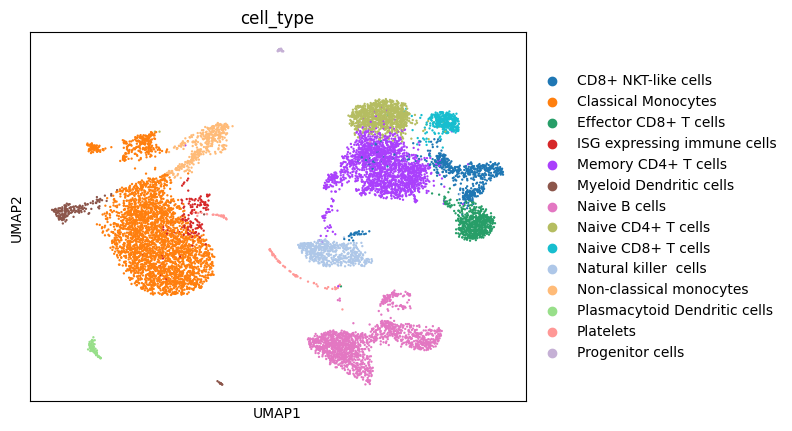

In [6]:
from sklearn.preprocessing import StandardScaler
vis_adata = adata.copy()
sc.pp.highly_variable_genes(vis_adata, n_top_genes=4000, flavor="cell_ranger")

# Scale data using dp.scale_data() to subtract data by the mean of each feature and divide by the std of that feature.
# This was done as a preprocessing step for annotating cell types in ScType in R and will therefore be used for visualization purpose. 
# https://github.com/satijalab/seurat/issues/1166  
vis_adata.X = dp.scale_data(vis_adata.X)

sc.pp.pca(vis_adata, n_comps=40, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(vis_adata, n_neighbors=15, n_pcs=40)
sc.tl.umap(vis_adata)
sc.pl.umap(vis_adata, color='cell_type')

c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


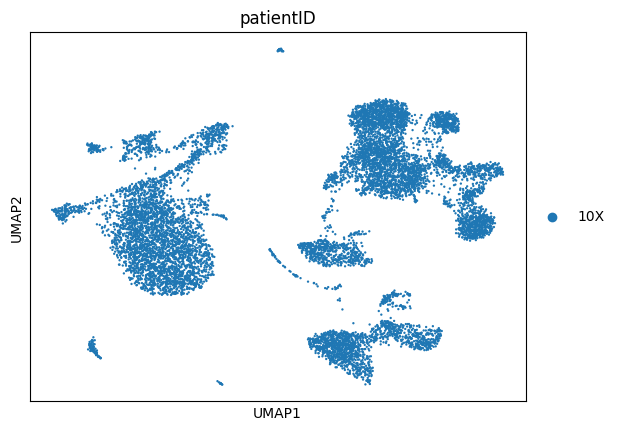

In [7]:
sc.pl.umap(vis_adata, color='patientID')

## Download processed data, including labels

In [8]:
adata.write("../../../../data/processed/immune_cells/merged/10X_merged.h5ad")